In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('..')
import open3d_tutorial
# change to True if you want to interact with the visualization windows
open3d_tutorial.interactive = not "CI" in os.environ

# Ray Casting

The `RaycastingScene` class in Open3D provides basic ray casting functionality.
In this tutorial we show how to create a scene and do ray intersection tests.

**Initialization**

As the first step we initialize a `RaycastingScene` with one or more triangle meshes.

In [2]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh
cube = o3d.geometry.TriangleMesh.create_box().translate([0, 0, 0])
cube = o3d.t.geometry.TriangleMesh.from_legacy(cube)

In [3]:
# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
cube_id = scene.add_triangles(cube)

`add_triangles()` returns the ID for the added geometry.
This ID can be used to identify which mesh is hit by a ray.

In [4]:
print(cube_id)

0


**Casting rays**

We can now generate rays which are 6D vectors with origin and direction.

In [5]:
# We create two rays:
# The first ray starts at (0.5,0.5,10) and has direction (0,0,-1).
# The second ray start at (-1,-1,-1) and has direction (0,0,-1).
rays = o3d.core.Tensor([[0.5, 0.5, 10, 0, 0, -1], [-1, -1, -1, 0, 0, -1]],
                       dtype=o3d.core.Dtype.Float32)

ans = scene.cast_rays(rays)

The result contains information about a possible intersection with the geometry in the scene.

In [6]:
print(ans.keys())

dict_keys(['primitive_normals', 'primitive_ids', 'primitive_uvs', 't_hit', 'geometry_ids'])


- **t_hit** is the distance to the intersection. The unit is defined by the length of the ray direction. If there is no intersection this is *inf*
- **geometry_ids** gives the id of the geometry hit by the ray. If no geometry was hit this is `RaycastingScene.INVALID_ID`
- **primitive_ids** is the triangle index of the triangle that was hit or `RaycastingScene.INVALID_ID`
- **primitive_uvs** is the barycentric coordinates of the intersection point within the triangle.
- **primitive_normals** is the normal of the hit triangle.

We can see from **t_hit** and **geometry_ids** that the first ray did hit the mesh but the second ray missed.

In [7]:
print(ans['t_hit'].numpy(), ans['geometry_ids'].numpy())

[8.999999      inf] [         0 4294967295]


**Creating images**

We now create a scene with multiple objects

In [8]:
# Create meshes and convert to open3d.t.geometry.TriangleMesh
cube = o3d.geometry.TriangleMesh.create_box().translate([0, 0, 0])
cube = o3d.t.geometry.TriangleMesh.from_legacy(cube)
torus = o3d.geometry.TriangleMesh.create_torus().translate([0, 0, 2])
torus = o3d.t.geometry.TriangleMesh.from_legacy(torus)
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5).translate(
    [1, 2, 3])
sphere = o3d.t.geometry.TriangleMesh.from_legacy(sphere)

scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(cube)
scene.add_triangles(torus)
_ = scene.add_triangles(sphere)

`RaycastingScene` allows to organize rays with an arbitrary number of leading dimensions.
For instance we can generate an array with shape `[h,w,6]` to organize rays for creating an image.
The class also provides helper functions for creating rays for a pinhole camera.
The following creates rays Tensor with shape `[240,320,6]`.

In [9]:
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[0, 0, 2],
    eye=[2, 3, 0],
    up=[0, 1, 0],
    width_px=640,
    height_px=480,
)
# Ee can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)

The output tensors preserve the shape of the rays and we can directly visualize the hit distance with matplotlib to get a depth map.

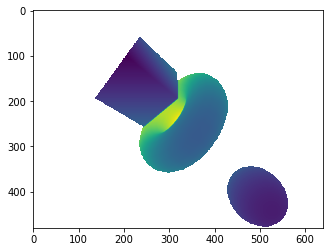

In [10]:
import matplotlib.pyplot as plt
plt.imshow(ans['t_hit'].numpy())

Furhter we can plot the other results to visualize the primitive normals, ..

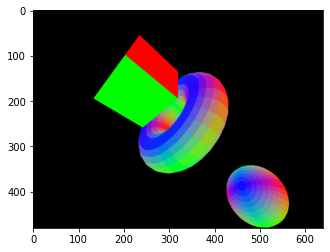

In [11]:
# use abs to avoid negative values
plt.imshow(np.abs(ans['primitive_normals'].numpy()))

.. or the geometry IDs.

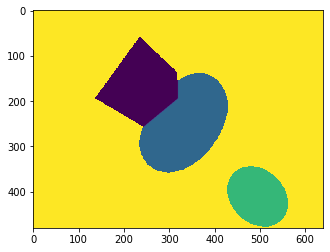

In [12]:
plt.imshow(ans['geometry_ids'].numpy(), vmax=3)